In [1]:
from itertools import cycle
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
# data gen
X = np.random.normal(0, 1, (1_000, 2))

In [3]:
# define our seperator (y = mx + b)
m, b = 2, -1.2

In [4]:
# do target classes
class_bool = X[:, 1] < m*X[:, 0] + b + np.random.normal(0, 0.5, (1000,))
y = -1.*class_bool + 1.*np.logical_not(class_bool)

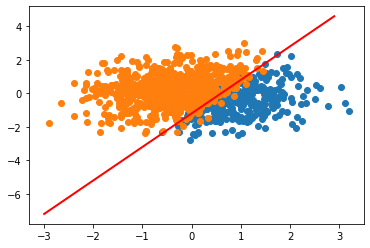

In [5]:
# visualize data
plt.scatter(X[class_bool, 0], X[class_bool, 1])
plt.scatter(X[np.logical_not(class_bool), 0], X[np.logical_not(class_bool), 1])
plt.plot(np.arange(-3, 3, 0.1), np.arange(-3, 3, 0.1)*m + b, linewidth=2, color="red")

In [6]:
class LinearSVM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.m = torch.nn.Parameter(torch.from_numpy(np.array([0.])), requires_grad=True)
        self.b = torch.nn.Parameter(torch.from_numpy(np.array([0.])), requires_grad=True)
    
    def forward_train(self, X):
        probs = torch.softmax(
            torch.stack([X[:, 0] * self.m + self.b, X[:, 1]], dim=1),
            dim=1
        )
        return -1.*probs[:,0] + 1.*probs[:,1]

    def forward_test(self, X):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X)
        class_bool = X[:, 1] < X[:, 0] * self.m + self.b
        return -1.*class_bool + 1.*torch.logical_not(class_bool)
    
    def __repr__(self):
        return f"{self.m}, {self.b}"


In [7]:
class NumpyRepeatDataset(torch.utils.data.IterableDataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
    
    def __iter__(self):
        self._iter_X = iter(cycle(self.X))
        self._iter_y = iter(cycle(self.y))
        return self

    def __next__(self):
        return next(self._iter_X), next(self._iter_y)

In [8]:
svm = LinearSVM()
optim = torch.optim.SGD(svm.parameters(), lr=0.1)
loss_fn = torch.nn.SoftMarginLoss()

In [9]:
train_dataset = NumpyRepeatDataset(X, y)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 20,
)
iter_train_dataloader = iter(train_dataloader)

In [10]:
for i in range(1_000):
    optim.zero_grad()
    t_X, t_y = next(iter_train_dataloader)
    output = svm.forward_train(t_X)
    loss = loss_fn(output, t_y)
    if (i+1) % 100 == 0:
        print(f"loss @ {i+1}th step: {loss}")
    loss.backward()
    optim.step()

loss @ 100th step: 0.5103311465154372
loss @ 200th step: 0.4747443935254365
loss @ 300th step: 0.4592316888784807
loss @ 400th step: 0.45088158654597327
loss @ 500th step: 0.4458161356800659
loss @ 600th step: 0.44251081862791086
loss @ 700th step: 0.44024942897845065
loss @ 800th step: 0.4386522843768912
loss @ 900th step: 0.4374999342012722
loss @ 1000th step: 0.43665709379792633


In [11]:
svm

Parameter containing:
tensor([2.9975], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-1.8330], dtype=torch.float64, requires_grad=True)

In [12]:
print(classification_report(
    y,
    svm.forward_test(X).numpy())
)

              precision    recall  f1-score   support

        -1.0       0.91      0.82      0.86       307
         1.0       0.93      0.96      0.94       693

    accuracy                           0.92      1000
   macro avg       0.92      0.89      0.90      1000
weighted avg       0.92      0.92      0.92      1000



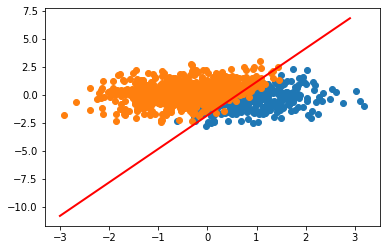

In [13]:
# visualize data
plt.scatter(X[class_bool, 0], X[class_bool, 1])
plt.scatter(X[np.logical_not(class_bool), 0], X[np.logical_not(class_bool), 1])
plt.plot(
    np.arange(-3, 3, 0.1), 
    np.arange(-3, 3, 0.1)*svm.m.detach().numpy() + svm.b.detach().numpy(), 
    linewidth=2, color="red"
)